**Dataset Preparation:**  

PlantDiseaseDataset: A custom dataset class that loads images and labels from a specified directory structure and a meta file. It also handles image transformation.
Image transformation pipeline: Resizing images to 256x256 and converting them to tensors.
Model Definition:

PrototypicalNetworks: A neural network class that uses a ResNet18 backbone for feature extraction. The network computes class prototypes and uses these to classify query images based on the Euclidean distance to the prototypes.
Model Loading:

Loading a pre-trained ResNet18 model as the backbone of the Prototypical Network.
**Data Visualization:**  

A function show_images to display a subset of images from the dataset along with their labels.
Evaluation Preparation:

TaskSampler: To create episodes for few-shot learning evaluation. Each episode consists of support and query sets.
DataLoader: For loading the data in batches according to the tasks defined by TaskSampler.
Evaluation:

Running the model in evaluation mode on the test set and displaying predictions for a batch of query images in a tabular format.

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from tqdm.notebook import tqdm
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import os
import json
from PIL import Image

In [2]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, meta_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(meta_file, 'r') as file:  # Safely open the file
            self.meta = json.load(file)
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.meta.keys())}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}
        self.images, self.labels = self._get_images_and_labels()
        
    def _get_images_and_labels(self):
        images = []
        labels = []
        for class_name, image_files in self.meta.items():
            for image_file in image_files:
                images.append(image_file + '.JPG') 
                labels.append(self.class_to_idx[class_name]) 
        return images, labels
        
    def __len__(self):
        return len(self.images)
    
    def get_labels(self):
        return self.labels

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "images", self.images[idx]) 
        try:
            image = Image.open(img_name).convert('RGB') 
            if self.transform:
                image = self.transform(image)
            label = self.labels[idx]
            return image, label
        except FileNotFoundError:
            print(f"File not found: {img_name}")
            return torch.zeros(3, self.image_size, self.image_size), -1


In [3]:
image_size = 50
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train_dataset = PlantDiseaseDataset(
    root_dir='./dataset',
    meta_file='./dataset/meta/train.json',
    transform=transform
)

test_dataset = PlantDiseaseDataset(
    root_dir='./dataset',
    meta_file='./dataset/meta/test.json',
    transform=transform
)

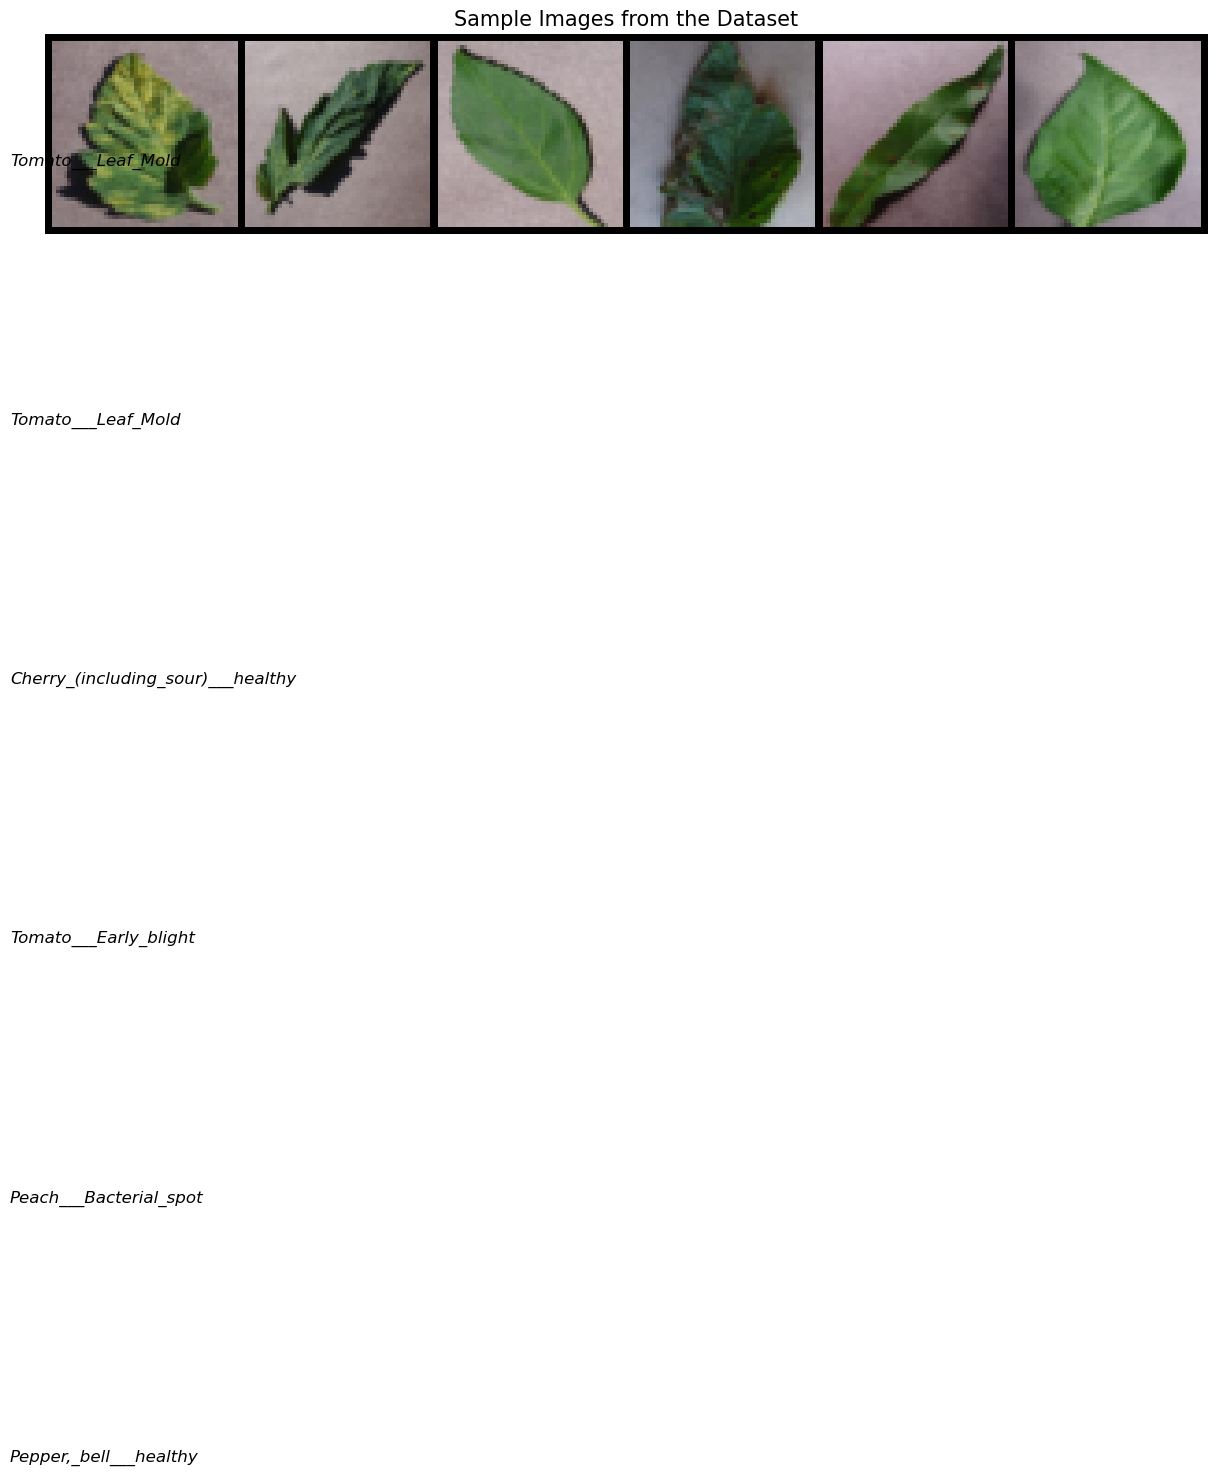

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show_images(images, labels, dataset, num_images=6):
    fig, ax = plt.subplots(figsize=(15, 10))
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    images = [images[i] for i in indices]
    labels = [labels[i] for i in indices]
    class_names = [dataset.idx_to_class[label.item()] for label in labels]  # Convert tensor to int
    ax.imshow(make_grid(images, nrow=num_images).permute(1, 2, 0))
    ax.axis('off')
    ax.set_title('Sample Images from the Dataset', size=15)
    for i, class_name in enumerate(class_names):
        plt.text(-10, 35 + i * 70, class_name, style='italic', wrap=True, fontsize=12)

images, labels = next(iter(DataLoader(train_dataset, batch_size=64, shuffle=True)))
show_images(images, labels, train_dataset)

### Prototypical Network

In [5]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


pn_convolutional_network = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
pn_convolutional_network.fc = nn.Flatten()

pn_model = PrototypicalNetworks(pn_convolutional_network)
print(pn_model)

PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [6]:
PN_N_WAY = 38  # Number of classes in a task
PN_N_SHOT = 20  # Number of images per class in the support set
PN_N_QUERY = 10  # Number of images per class in the query set
PN_N_EVALUATION_TASKS = 100

In [7]:
test_sampler = TaskSampler(
    test_dataset, n_way=PN_N_WAY, n_shot=PN_N_SHOT, n_query=PN_N_QUERY, n_tasks=PN_N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=False,  # False = not using CUDA
    collate_fn=test_sampler.episodic_collate_fn,
)

### Model Evaluation

In [8]:
pn_model.eval()
all_ground_truths = []
all_predictions = []

with torch.no_grad():
    for example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids in test_loader:
        example_scores = pn_model(example_support_images, example_support_labels, example_query_images)
        _, example_predicted_labels = torch.max(example_scores.data, 1)
        
        # Collect all ground truths and predictions for metrics calculation
        all_ground_truths.extend(example_query_labels.cpu().numpy())
        all_predictions.extend(example_predicted_labels.cpu().numpy())
        
        # Prepare data for tabulation for each batch
        table_data = []
        for i in range(len(example_query_labels)):
            ground_truth_class = test_dataset.idx_to_class[example_query_labels[i].item()]
            predicted_class = test_dataset.idx_to_class[example_predicted_labels[i].item()]
            table_data.append([ground_truth_class, predicted_class])
        
        # Print the table for each batch
        print("Some example predictions on query images:")
        print(tabulate(table_data, headers=["Ground Truth", "Predicted"], tablefmt="grid"))
        break  # Remove this if you want to see predictions for all batches

# Calculate and print metrics
accuracy = accuracy_score(all_ground_truths, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_ground_truths, all_predictions, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Some example predictions on query images:
+----------------------------------------------------+----------------------------------------------------+
| Ground Truth                                       | Predicted                                          |
+====================================================+====================================================+
| Raspberry___healthy                                | Strawberry___healthy                               |
+----------------------------------------------------+----------------------------------------------------+
| Raspberry___healthy                                | Grape___healthy                                    |
+----------------------------------------------------+----------------------------------------------------+
| Raspberry___healthy                                | Cherry_(including_sour)___healthy                  |
+----------------------------------------------------+----------------------------------------

### Training Model

In [9]:
# Define the batch sampler for episodic training
train_sampler = TaskSampler(
    train_dataset, 
    n_way=PN_N_WAY, 
    n_shot=PN_N_SHOT, 
    n_query=PN_N_QUERY, 
    n_tasks=PN_N_EVALUATION_TASKS
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=0,  # Use 0 for main thread, adjust as per your system's capabilities
    pin_memory=False,  # Set to False since we're not using CUDA
    collate_fn=train_sampler.episodic_collate_fn,  # Use the episodic collate function from easyfsl
)

In [10]:
pn_model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pn_model.parameters(), lr=0.001)

num_epochs = 4
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        support_images, support_labels, query_images, query_labels, _ = data
        optimizer.zero_grad()
        scores = pn_model(support_images, support_labels, query_images)
        _, predicted_labels = torch.max(scores, 1)
        loss = criterion(scores, query_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct_predictions += (predicted_labels == query_labels).sum().item()
        total_predictions += query_labels.size(0)
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy*100:.2f}%")

Epoch 1/4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.3136889125406742, Accuracy: 90.80%


Epoch 2/4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.0971189496293664, Accuracy: 97.00%


Epoch 3/4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.05715859588235617, Accuracy: 98.18%


Epoch 4/4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.04238428900949657, Accuracy: 98.69%


In [11]:
torch.save(pn_model.state_dict(), 'prototypical_network_model_50.pth')

### Evaluation

In [12]:
# Assuming `pn_model` is the prototypical network model architecture
pn_model.load_state_dict(torch.load('prototypical_network_model_50.pth'))

<All keys matched successfully>

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

true_labels = []
predicted_labels_list = []

pn_model.eval() 

with torch.no_grad():  # No need to track gradients for evaluation
    for data in tqdm(test_loader, desc="Evaluating", leave=False):
        support_images, support_labels, query_images, query_labels, _ = data
        
        # Forward pass
        scores = pn_model(support_images, support_labels, query_images)
        _, predicted = torch.max(scores, 1)
        
        # Collect all true labels and predicted labels
        true_labels.extend(query_labels.cpu().numpy())
        predicted_labels_list.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels_list)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 96.18%
Precision: 96.22%
Recall: 96.18%
F1-Score: 96.19%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.92      0.94      0.93      1000
           2       0.99      0.98      0.98      1000
           3       0.99      0.98      0.98      1000
           4       1.00      1.00      1.00      1000
           5       0.89      0.92      0.90      1000
           6       0.99      0.99      0.99      1000
           7       0.92      0.95      0.93      1000
           8       0.89      0.92      0.90      1000
           9       0.98      0.99      0.99      1000
          10       0.98      0.94      0.96      1000
          11       1.00      0.97      0.98      1000
          12       0.95      0.94      0.95      1000
          13       0.98      0.98      0.98      1000
          14       0.99      0.99      0.99      1000
          15       0.98      0.97      0.98

In [18]:
import pickle
# from sklearn.svm import LinearSVC

In [19]:
with open('al_agri_disease_model.pkl', 'wb') as file:
    pickle.dump(pn_model, file)

NameError: name 'LinSVC' is not defined